In [161]:
# define experiment
import json
import itertools

from src.plot import *
from matplotlib.cm import get_cmap


def print_info(error_type, skew, heteroscedasticity):
    ret = ""
    if error_type == 0:
        ret += "Standart Normal, "
    else:
        ret += f"Student's with df={error_type}, "
    if skew:
        ret += "with skew "
    else:
        ret += "without skew "
    if heteroscedasticity:
        ret += "and with heteroscedasticity."
    else:
        ret += "and without heteroscedasticity."
    print(ret)       


# Notebook to reproduce figures of the main text and supplementary material

Notice that all figures are saved in a <code>plots/</code> directory, thus make sure a directory with this name exits.

## Setup A figures

The following code produces figures similar to the one shown in Setup A, but for several variations of data distribution.

Standart Normal, without skew and without heteroscedasticity.
Standart Normal, without skew and with heteroscedasticity.
Standart Normal, with skew and without heteroscedasticity.
Standart Normal, with skew and with heteroscedasticity.
Student's with df=1, without skew and without heteroscedasticity.
Student's with df=1, without skew and with heteroscedasticity.
Student's with df=1, with skew and without heteroscedasticity.
Student's with df=1, with skew and with heteroscedasticity.
Student's with df=2, without skew and without heteroscedasticity.
Student's with df=2, without skew and with heteroscedasticity.
Student's with df=2, with skew and without heteroscedasticity.
Student's with df=2, with skew and with heteroscedasticity.
Standart Normal, without skew and without heteroscedasticity.
Standart Normal, without skew and with heteroscedasticity.
Standart Normal, with skew and without heteroscedasticity.
Standart Normal, with skew and with heteroscedasticity.
Student's with df=1, wit

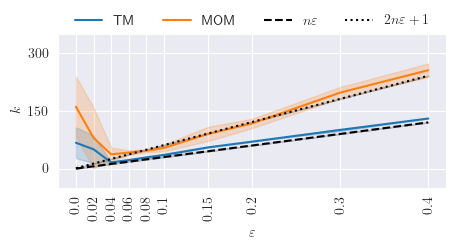

In [4]:
error_types = [0,1,2,4]
skews = [False, True]
heteroscedasticitys = [False, True]

for algorithm in ["admm", "plugin"]:
    results = json.load(open(f"results/setupA_{algorithm}.json", "r"))

    for error_type, skew, heteroscedasticity in itertools.product(error_types, skews, heteroscedasticitys):
        print_info(error_type, skew, heteroscedasticity)
        make_plot_setup_error(
            results,
            {"error_type": error_type,
            "skew": skew,
            "heteroscedasticity": heteroscedasticity,
            "cv_strategy": "max_slope",
            "beta_strategy": "best"
            },
            savefig=True
        )
        make_plot_setup_parameter(
            results,
            {"error_type": error_type,
            "skew": skew,
            "heteroscedasticity": heteroscedasticity,
            "cv_strategy": "max_slope",
            "beta_strategy": "best"
            },
            savefig=True
        )

## Setup B figures

The figures for setup B are all generated by the code below:

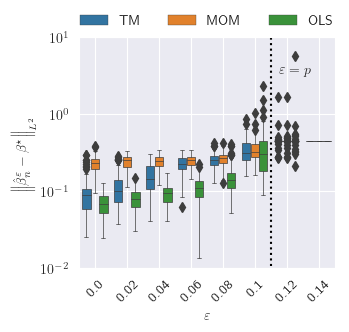

In [74]:
results = json.load(open("results/setupB_admm.json", "r"))

for p in [.03, .07, .11]:
    make_plot_setup_error(
        results,
        {
            "p": p,
            "cv_strategy": "max_slope",
            "beta_strategy": "best"
        },
        savefig=True,
        vertical_at=50*p,
        vertical_label=fr"$\varepsilon=p$",
        ylims=(0.01, 10),
        figsize=(3.3,3)
    )

# Choosing the method

We now investigate the following questions:
- Should one choose the last beta or the beta minimizing the robust estimate of the empirical loss, i.e., last_beta or min_beta?
- What is the best choice of cross-validation strategy (min_loss or max_slope)?
- What algorithm performs best: ADMM or Plug-in?

In [179]:
# gathering experimental results
def get_config(row):
    if row["type"] == "NormalContaminated":
        skew = row["skew"]
        h = row["heteroscedasticity"]
        if row["error_type"]:
            return f"A: Student with df={row['error_type']}, {skew}, {h}"
        else:
            return f"A: Normal, {skew}, {h}"
    else:
        return f"B: p={row['p']}"

def get_setup(row):
    if row["type"] == "NormalContaminated":
        if row["error_type"]:
            return f"A: Student with df={row['error_type']}"
        else:
            return f"A: Normal"
    else:
        return "B"

results = pd.DataFrame(
    json.load(open(f"results/setupA_plugin.json", "r")) + json.load(open(f"results/setupA_admm.json", "r"))
    + json.load(open(f"results/setupB_plugin.json", "r")) + json.load(open(f"results/setupB_admm.json", "r"))
)
results = results[ results.method != "OLS" ]
results["eps"] = results["sample_contaminated"]/results["sample_size"]
results["config"] = results.apply(lambda row: get_config(row), axis=1)
results["setup"] = results.apply(lambda row: get_setup(row), axis=1)
del results["params"]
del results["beta_hat"]
del results["time"]
del results["block_kind"]
del results["sample_size"]
del results["sample_contaminated"]
del results["error_type"]
del results["type"]
del results["heteroscedasticity"]
del results["skew"]
del results["p"]

f_results = results.groupby(by=["method", "algorithm", "config", "setup", "cv_strategy", "beta_strategy", "eps"]).mean().reset_index()
del f_results["seed"]

In [197]:
M_tms = []
M_moms = []
M_tm_params = []
M_mom_params = []
algs_cvs = []

epss = np.array([0.0, 0.02, 0.04, 0.06, 0.08, 0.1, 0.15, 0.2, 0.3, 0.4])
configs = {
    'A: Normal, False, False': "Normal",
    'A: Normal, False, True': "Normal with ht.",
    'A: Normal, True, False': "Normal with skew",
    'A: Normal, True, True': "Normal with ht. and skew",
    'A: Student with df=1.0, False, False': "Student(1)",
    'A: Student with df=1.0, False, True': "Student(1) with ht.",
    'A: Student with df=1.0, True, False': "Student(1) with skew",
    'A: Student with df=1.0, True, True': "Student(1) with ht. and skew",
    'A: Student with df=2.0, False, False': "Student(2)",
    'A: Student with df=2.0, False, True': "Student(2) with ht.",
    'A: Student with df=2.0, True, False': "Student(2) with skew",
    'A: Student with df=2.0, True, True': "Student(2) with ht. and skew",
    'A: Student with df=4.0, False, False': "Student(4)",
    'A: Student with df=4.0, False, True': "Student(4) with ht.",
    'A: Student with df=4.0, True, False': "Student(4) with skew",
    'A: Student with df=4.0, True, True': "Student(4) with ht. and skew",
}

for cv_strategy in ["max_slope", "min_loss"]:
    for algorithm in ["admm", "plugin"]:
        algs_cvs.append( algorithm + cv_strategy )
        results = f_results[
            (f_results.beta_strategy == "best") & (f_results.setup.isin(["A: Normal", "A: Student with df=1.0", "A: Student with df=2.0", "A: Student with df=4.0"]))
            & (f_results.cv_strategy == cv_strategy) & (f_results.algorithm == algorithm)
        ]

        M_tm = np.zeros(( len(configs), epss.size ))
        M_mom = np.zeros(( len(configs), epss.size ))
        M_tm_param = np.zeros(( len(configs), epss.size ))
        M_mom_param = np.zeros(( len(configs), epss.size ))
        for i, config in enumerate(configs):
            for j, eps in enumerate(epss):                
                M_tm[i][j] = results.L2_dist[(results.eps == eps) & (results.config == config) & (results.method == "TM")].values[0]
                M_mom[i][j] = results.L2_dist[(results.eps == eps) & (results.config == config) & (results.method == "MOM")].values[0]
                M_tm_param[i][j] = results.best_param[(results.eps == eps) & (results.config == config) & (results.method == "TM")].values[0]
                M_mom_param[i][j] = results.best_param[(results.eps == eps) & (results.config == config) & (results.method == "MOM")].values[0]
        M_tms.append(M_tm)
        M_moms.append(M_mom)
        M_tm_params.append(M_tm_param)
        M_mom_params.append(M_mom_param)

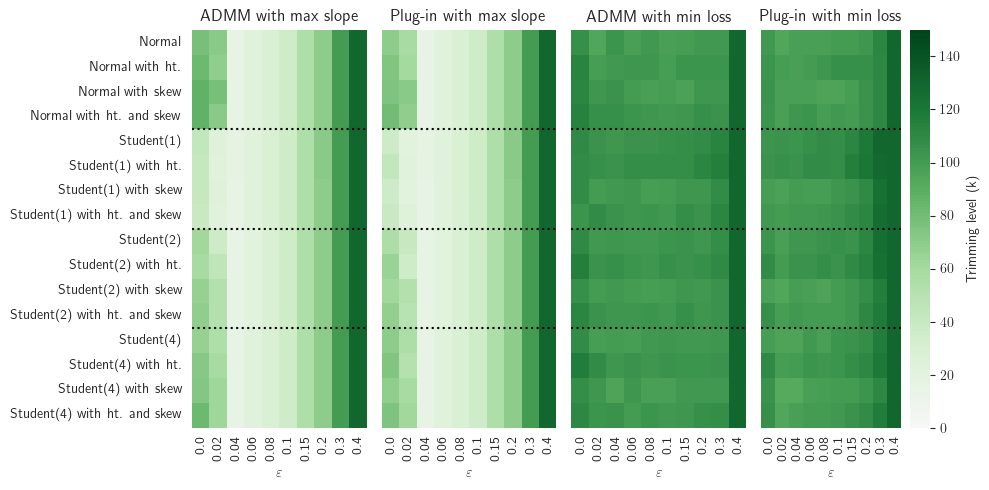

In [216]:
titles = [
    "ADMM with max slope",
    "Plug-in with max slope",
    "ADMM with min loss",
    "Plug-in with min loss",
]

fig, axs = plt.subplots(ncols=4, figsize=(10, 5), sharey=True)
for i, ax in enumerate(axs.flat):
    sns.heatmap(
        M_tm_params[i]*300,
        xticklabels=epss,
        yticklabels=[configs[k] for k in configs],
        cmap="PRGn", center=0, ax=axs[i], vmin=0, vmax=150,
        cbar=i == 3,
        cbar_kws={'label': 'Trimming level (k)'}
    )
    ax.hlines([4, 8, 12], *ax.get_xlim(), colors="black", linestyles=":")
    ax.set_xlabel(r"$\varepsilon$")
    ax.set_title(titles[i])
    
plt.tight_layout()
plt.savefig(f"plots/trimming_levels.pdf", bbox_inches='tight', pad_inches=0)

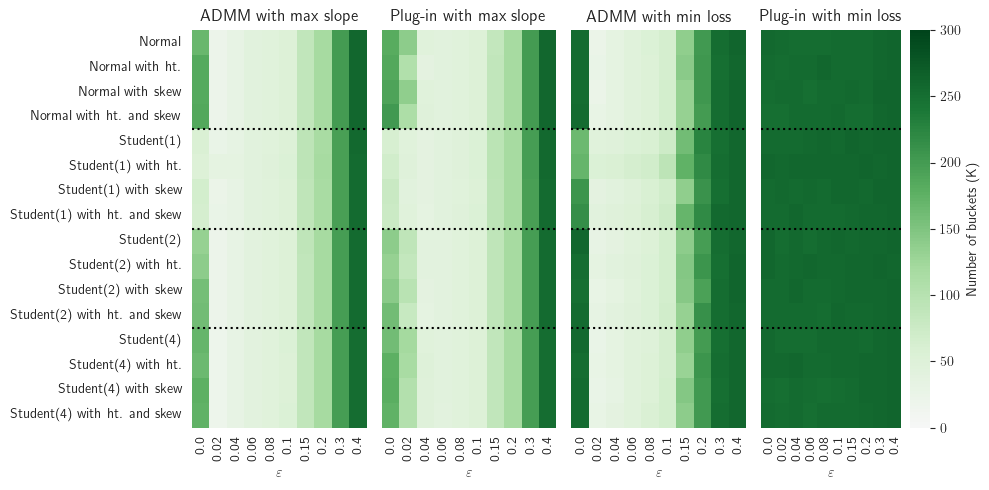

In [217]:
fig, axs = plt.subplots(ncols=4, figsize=(10, 5), sharey=True)
for i, ax in enumerate(axs.flat):
    sns.heatmap(
        M_mom_params[i],
        xticklabels=epss,
        yticklabels=[configs[k] for k in configs],
        cmap="PRGn", center=0, ax=axs[i], vmin=0, vmax=300,
        cbar=i == 3,
        cbar_kws={'label': 'Number of buckets (K)'}
    )
    ax.hlines([4, 8, 12], *ax.get_xlim(), colors="black", linestyles=":")
    ax.set_xlabel(r"$\varepsilon$")
    ax.set_title(titles[i])
    
plt.tight_layout()
plt.savefig(f"plots/number_of_buckets.pdf", bbox_inches='tight', pad_inches=0)

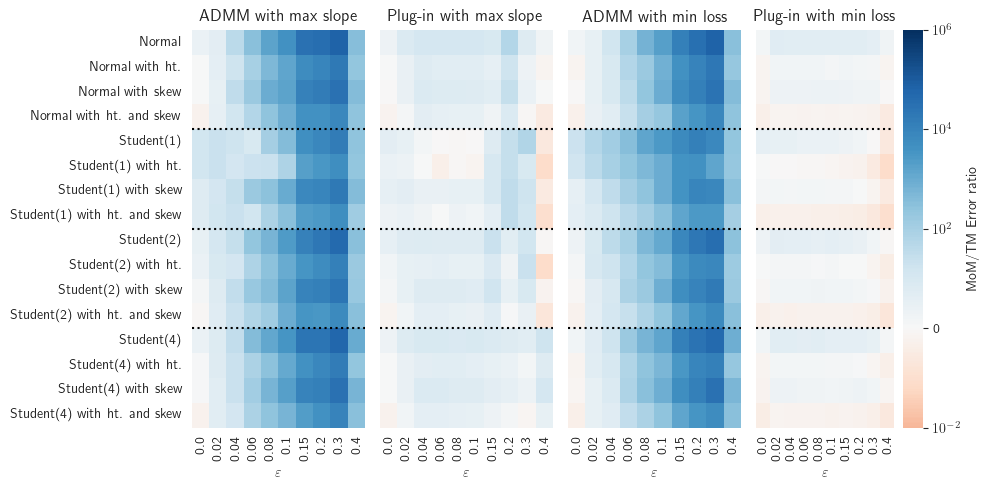

In [211]:
fig, axs = plt.subplots(ncols=4, figsize=(10, 5), sharey=True)
for i, ax in enumerate(axs.flat):
    sns.heatmap(
        np.log(M_moms[i]/M_tms[i]),
        xticklabels=epss,
        yticklabels=[configs[k] for k in configs],
        cmap="RdBu", center=0, ax=axs[i], vmin=-2, vmax=6,
        cbar=i == 3,
        cbar_kws={'label': 'MoM/TM Error ratio'}
    )
    ax.hlines([4, 8, 12], *ax.get_xlim(), colors="black", linestyles=":")
    ax.set_xlabel(r"$\varepsilon$")
    ax.set_title(titles[i])
    if i==3:
        colorbar = axs[i].collections[0].colorbar
        colorbar.set_ticks([-2,0,2,4,6])
        colorbar.set_ticklabels([r"$10^{-2}$","0",r"$10^{2}$",r"$10^{4}$",r"$10^{6}$"])

plt.tight_layout()
plt.savefig(f"plots/error_ratio.pdf", bbox_inches='tight', pad_inches=0)

/tmp/ipykernel_783040/3771575902.py:42: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap('PRGn')


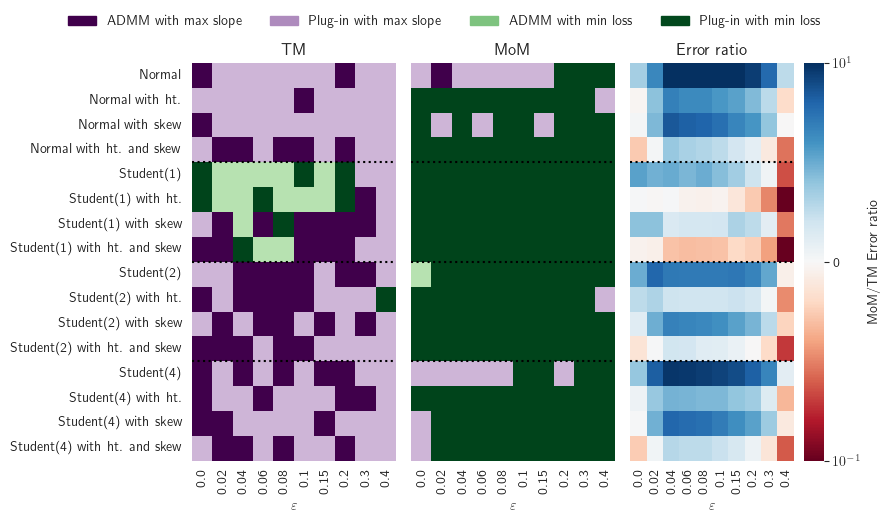

In [218]:
fig, axs = plt.subplots(ncols=3, figsize=(9, 5), sharey=True)

best_tm_strategy = np.argmin(np.array(M_tms), axis=0)
sns.heatmap(
    best_tm_strategy,
    xticklabels=epss,
    yticklabels=[configs[k] for k in configs],
    cmap="PRGn", center=1.5, ax=axs[0], vmin=0, vmax=3,
    cbar=False
)
axs[0].set_xlabel(r"$\varepsilon$")
axs[0].set_title("TM")
axs[0].hlines([4, 8, 12], *ax.get_xlim(), colors="black", linestyles=":")

best_mom_strategy = np.argmin(np.array(M_moms), axis=0)
sns.heatmap(
    best_mom_strategy,
    xticklabels=epss,
    yticklabels=[configs[k] for k in configs],
    cmap="PRGn", center=1.5, ax=axs[1], vmin=0, vmax=3,
    cbar=False
)
axs[1].set_xlabel(r"$\varepsilon$")
axs[1].set_title("MoM")
axs[1].hlines([4, 8, 12], *ax.get_xlim(), colors="black", linestyles=":")

best_strategy_error = np.min(np.array(M_moms), axis=0)/np.min(np.array(M_tms), axis=0)
sns.heatmap(
    np.log(best_strategy_error),
    xticklabels=epss,
    yticklabels=[configs[k] for k in configs],
    cmap="RdBu", center=0, ax=axs[2], vmin=-1, vmax=1,
    cbar_kws={'label': 'MoM/TM Error ratio'}
)
axs[2].hlines([4, 8, 12], *ax.get_xlim(), colors="black", linestyles=":")
axs[2].set_xlabel(r"$\varepsilon$")
axs[2].set_title("Error ratio")
colorbar = axs[2].collections[0].colorbar
colorbar.set_ticks([-1,0,1])
colorbar.set_ticklabels([r"$10^{-1}$","0",r"$10^{1}$"])

cmap = get_cmap('PRGn')
fig.legend(
    handles=[
        mpatches.Patch(color=cmap(0), label=titles[0]),
        mpatches.Patch(color=cmap(.25), label=titles[1]),
        mpatches.Patch(color=cmap(.75), label=titles[2]),
        mpatches.Patch(color=cmap(.99), label=titles[3])
    ],
    loc="upper center", bbox_to_anchor=(0.5, 1.05), ncol=4, frameon=False
)
plt.tight_layout()
plt.savefig(f"plots/best_error_ratio.pdf", bbox_inches='tight', pad_inches=0)

## Best_beta vs last_beta

In [229]:
for algorithm in ["plugin", "admm"]:
    for i, method in enumerate(["MOM", "TM"]):
        best_results = f_results[(f_results.method == method) & (f_results.beta_strategy == "best") & (f_results.algorithm == algorithm)]
        last_results = f_results[(f_results.method == method) & (f_results.beta_strategy == "last") & (f_results.algorithm == algorithm)]
        best_results["best"] = best_results["L2_dist"].copy()
        last_results["last"] = last_results["L2_dist"].copy()
        del best_results["L2_dist"]
        del last_results["L2_dist"]
        del best_results["beta_strategy"]
        del last_results["beta_strategy"]

        joined = pd.merge(best_results, last_results, on=['method', 'algorithm', 'cv_strategy', 'eps', 'setup', 'config'])
        ratios = np.log((joined["last"][ joined.config == "A: Normal, False, False" ]/joined["best"][ joined.config == "A: Normal, False, False" ]).values)
        m = ratios.mean()
        print(f"The selection of the beta minimizing the empirical loss was better than the last beta for the {method} using {algorithm} {int(p*100)}% of the time")

The selection of the beta minimizing the empirical loss was 0.1781186677067632 +/- 0.4309814364424048 times better than the last beta for the MOM using plugin
The selection of the beta minimizing the empirical loss was 2.2965712515866876 +/- 1.4017651807717937 times better than the last beta for the TM using plugin
The selection of the beta minimizing the empirical loss was 1.1726924532067975 +/- 0.6914876133090194 times better than the last beta for the MOM using admm
The selection of the beta minimizing the empirical loss was 0.90118021219028 +/- 0.8176382195954021 times better than the last beta for the TM using admm


/tmp/ipykernel_783040/2249887270.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  best_results["best"] = best_results["L2_dist"].copy()
/tmp/ipykernel_783040/2249887270.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_results["last"] = last_results["L2_dist"].copy()
/tmp/ipykernel_783040/2249887270.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://

Thus, taking the besta beta is better than taking the last beta in both methods and for both crossover strategies.

## Min. loss vs Max slope

/tmp/ipykernel_425730/2908394478.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  min_results["min_loss"] = min_results["L2_dist"].copy()
/tmp/ipykernel_425730/2908394478.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  max_results["max_slope"] = max_results["L2_dist"].copy()
/tmp/ipykernel_425730/2908394478.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: htt

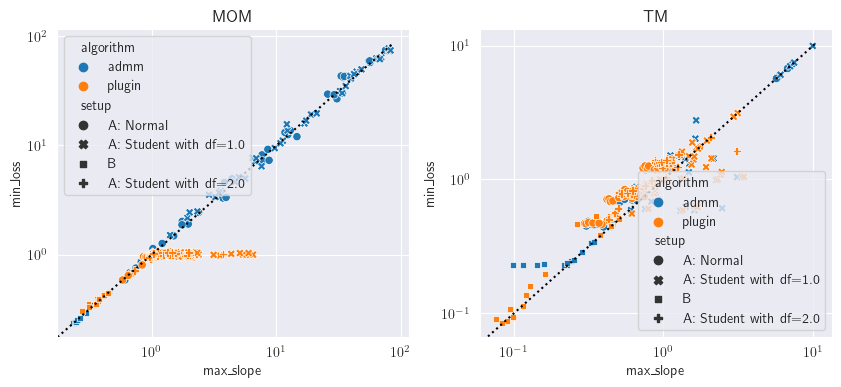

In [157]:
import seaborn as sns
plt.rcParams["figure.figsize"] = (10,4)

for i, method in enumerate(["MOM", "TM"]):
    min_results = f_results[(f_results.method == method) & (f_results.beta_strategy == "best") & (f_results.cv_strategy == "min_loss")]
    max_results = f_results[(f_results.method == method) & (f_results.beta_strategy == "best") & (f_results.cv_strategy == "max_slope")]
    min_results["min_loss"] = min_results["L2_dist"].copy()
    max_results["max_slope"] = max_results["L2_dist"].copy()
    del min_results["L2_dist"]
    del max_results["L2_dist"]
    del min_results["cv_strategy"]
    del max_results["cv_strategy"]

    plt.subplot(1,2,i+1)
    joined = pd.merge(min_results, max_results,
        on=['method', 'algorithm', 'beta_strategy', 'eps', 'config', 'setup'],
        suffixes=["_min_loss", "_max_slope"]
    )
    sns.scatterplot(joined, x="max_slope", y="min_loss", hue="algorithm", style="setup")
    plt.plot(plt.xlim(), plt.xlim(), ls=":", color="black")
    plt.loglog()
    plt.title(method)


The max slope seems better when the error type is 1 (student with parameter 1), meaning that it performs better on heavy-tailored errors. It is also better for the TM in all cases.

An interesting behavior occurs for the Median of Means using the plugin method on Setup A with student error with df=1: the error obtained by the min_loss keeps constant while the error obtained by the max_slope increases.

As the histogram in the next figure shows, this is because when the error is student with df=1 the min loss approach is almost always selecting K=250 to be the number of buckets for the MoM, making it every close to the median itself.

Text(0.5, 1.0, 'Histogram of hyperparameter choice for cv strategies')

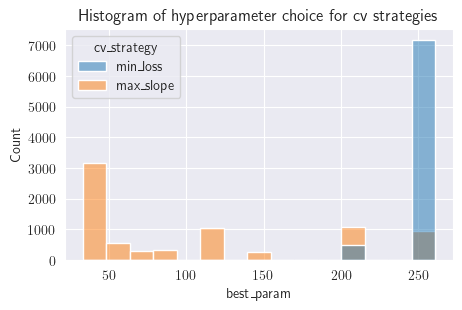

In [160]:
import seaborn as sns
plt.rcParams["figure.figsize"] = (5,3)

sns.histplot(
    results[ (results.algorithm == "plugin") & (results.method == "MOM") & (results.beta_strategy == "best") & (results.setup == "A: Student with df=2.0")],
    x="best_param", hue="cv_strategy"
)

plt.title("Histogram of hyperparameter choice for cv strategies")

## ADMM vs Plugin

The following figure helps to answer if the Plugin is a better alternative for the ADMM. The Plugin has a higher advantage in the MoM, but is also very competitive on the TM estimator. 

/tmp/ipykernel_425730/3022900586.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  p_results["plugin"] = p_results["L2_dist"].copy()
/tmp/ipykernel_425730/3022900586.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  a_results["admm"] = a_results["L2_dist"].copy()
/tmp/ipykernel_425730/3022900586.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyd

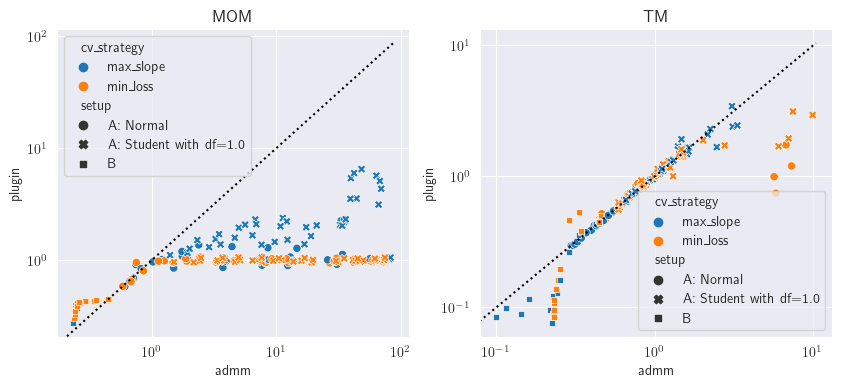

In [166]:
import seaborn as sns
plt.rcParams["figure.figsize"] = (10,4)

for i, method in enumerate(["MOM", "TM"]):
    p_results = f_results[(f_results.method == method) & (f_results.beta_strategy == "best") & (f_results.algorithm == "plugin")]
    a_results = f_results[(f_results.method == method) & (f_results.beta_strategy == "best") & (f_results.algorithm == "admm")]
    p_results["plugin"] = p_results["L2_dist"].copy()
    a_results["admm"] = a_results["L2_dist"].copy()
    del p_results["L2_dist"]
    del a_results["L2_dist"]
    del p_results["algorithm"]
    del a_results["algorithm"]

    plt.subplot(1,2,i+1)
    joined = pd.merge(p_results, a_results,
        on=['method', 'cv_strategy', 'beta_strategy', 'eps', 'config', 'setup'],
        suffixes=["_min_loss", "_max_slope"]
    )
    sns.scatterplot(joined, x="admm", y="plugin", style="setup", hue="cv_strategy")
    plt.plot(plt.xlim(), plt.xlim(), ls=":", color="black")
    plt.loglog()
    plt.title(method)
